In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns 
from datetime import datetime, timedelta, timezone
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

 ## Introduction

This notebook is done as party of the project in the course.... The aim is to predict the total electric consumption of France (in MW) on the 8th of December using time series data gathered from : https://odre.opendatasoft.com/explore/dataset/eco2mix-national-tr/information/

## Data preparation

In [2]:
# Importing data 
data=pd.read_csv("eco2mix-national-tr.csv", sep=";")

In [3]:
# Insights on data
## Number of samples
print(f"Number of samples is {data.count()[0]}")
## Head of dataframe
data.head()

Number of samples is 17664


,Périmètre,Nature,Date,Heure,Date - Heure,Consommation (MW),Prévision J-1 (MW),Prévision J (MW),Fioul (MW),Charbon (MW),...,Hydraulique - Fil de l'eau + éclusée (MW),Hydraulique - Lacs (MW),Hydraulique - STEP turbinage (MW),Bioénergies - Déchets (MW),Bioénergies - Biomasse (MW),Bioénergies - Biogaz (MW),Stockage batterie (MW),Déstockage batterie (MW),Eolien terrestre (MW),Eolien offshore (MW)
0,France,Données temps réel,2022-06-01,00:00,2022-06-01T10:00:00+12:00,44940.0,44800.0,45100.0,144.0,0.0,...,4331.0,1054.0,1677.0,170.0,584.0,286.0,ND,ND,ND,ND
1,France,Données temps réel,2022-06-01,02:15,2022-06-01T12:15:00+12:00,39778.0,39450.0,39600.0,143.0,6.0,...,4053.0,840.0,272.0,176.0,564.0,276.0,ND,ND,ND,ND
2,France,Données temps réel,2022-06-01,05:15,2022-06-01T15:15:00+12:00,37506.0,37150.0,37200.0,144.0,7.0,...,3851.0,610.0,226.0,159.0,562.0,276.0,ND,ND,ND,ND
3,France,Données temps réel,2022-06-01,07:15,2022-06-01T17:15:00+12:00,44259.0,44650.0,44150.0,144.0,10.0,...,4506.0,1302.0,855.0,163.0,568.0,276.0,ND,ND,ND,ND
4,France,Données temps réel,2022-06-01,07:30,2022-06-01T17:30:00+12:00,45062.0,45700.0,45100.0,144.0,10.0,...,4522.0,1314.0,984.0,160.0,568.0,276.0,ND,ND,ND,ND


## Data cleaning

In [4]:
# Some columns contain missing values or are irrelevant (same value everywhere)
print(data["Eolien terrestre (MW)"].value_counts())
print(data["Stockage batterie (MW)"].value_counts()) 
print(data["Périmètre"].value_counts())

ND    17528
Name: Eolien terrestre (MW), dtype: int64
ND    17528
Name: Stockage batterie (MW), dtype: int64
France    17664
Name: Périmètre, dtype: int64


In [5]:
# Remove the unnecessary columns
columns_to_drop=["Périmètre","Nature","Prévision J-1 (MW)","Prévision J (MW)", "Stockage batterie (MW)", "Déstockage batterie (MW)", "Eolien terrestre (MW)", "Eolien offshore (MW)"]
data.drop(columns=columns_to_drop, inplace= True)

In [6]:
# Remove duplicate values 
data.drop_duplicates(subset=["Date - Heure"], inplace=True)

In [7]:
# Remove rows containg empty values
data.dropna(subset=["Date - Heure", "Consommation (MW)"], inplace = True)
print(f"Number of samples is {data.count()[0]}")

Number of samples is 17528


## Data reformatting

In [8]:
# Converting date column to datetime format and set time column as index
data['Time'] = data[['Date', 'Heure']].agg(' '.join, axis=1)
data["Time"]=pd.to_datetime(data["Time"])
data["Date"]= pd.to_datetime(data["Date"])
data["Heure"]=pd.to_datetime(data["Heure"])
data.set_index("Time", inplace=True)
data.drop(columns=["Date - Heure"], inplace= True)

In [9]:
# Sorting data chronologically
data=data.sort_index(ascending=True)

In [10]:
data=data.loc[data['Date'] >= '2022-09-24']

In [11]:
data.count()

Date                                         6488
Heure                                        6488
Consommation (MW)                            6488
Fioul (MW)                                   6488
Charbon (MW)                                 6488
Gaz (MW)                                     6488
Nucléaire (MW)                               6488
Eolien (MW)                                  6488
Solaire (MW)                                 6488
Hydraulique (MW)                             6488
Pompage (MW)                                 6488
Bioénergies (MW)                             6488
Ech. physiques (MW)                          6488
Taux de CO2 (g/kWh)                          6488
Ech. comm. Angleterre (MW)                   3244
Ech. comm. Espagne (MW)                      3244
Ech. comm. Italie (MW)                       3244
Ech. comm. Suisse (MW)                       3244
Ech. comm. Allemagne-Belgique (MW)           3244
Fioul - TAC (MW)                             6488


## Data vizualization

<AxesSubplot:>

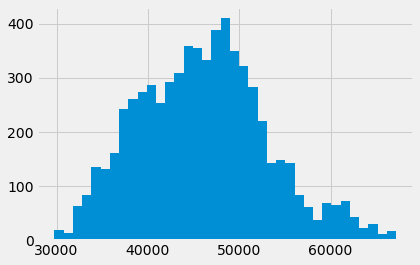

In [13]:
# Plotting the distribution of Consommation (MW)
data["Consommation (MW)"].hist(bins='auto')

Text(0.5, 1.0, 'Electricity consumption over time')

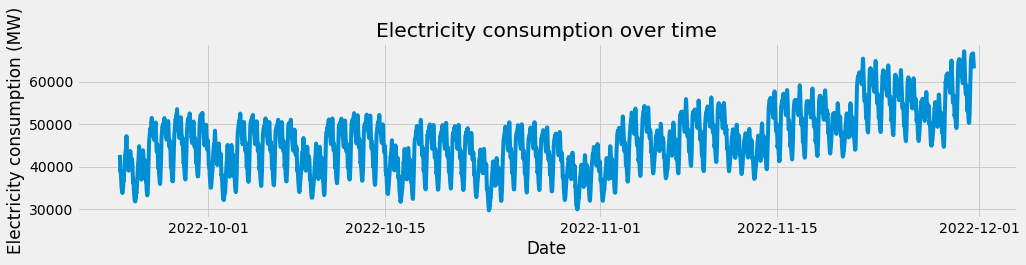

In [14]:
# Plotting the distribution of Consommation (MW)
plt.figure(figsize=(15, 3))
plt.plot(data["Consommation (MW)"],label='Consommation')
plt.xlabel("Date")
plt.ylabel("Electricity consumption (MW)")
plt.title("Electricity consumption over time")

Since we'll try to predict the electricity consumption within a single day, we can keep only recent observations (5 weeks).